# Two particle equilibrium

If you haven't read the `One particle equilibrium` notebook yet, go and read it now.

In the previous notebook we showed that we can use Magpy to compute the correct thermal equilibrium for a single particle. However, we also need to check that the interactions are correctly implemented by simulating the thermal equilibrium of multiple interacting particles.

In this notebook we'll simulate an ensemble of two particle systems with Magpy. Instead of computing the distribution analytically, we will use the Metropolis Markov-Chain Monte-Carlo technique to generate the correct equilibrium.

**Acknowledgements**

Many thanks to [Jonathon Waters](https://github.com/waterswims) for the terse python implementation of the Metropolis algorithm!

**Problem setup**

![dimer](dimer-diagram.png)

In this example the system comprises two identical particles separated by a distance $R$. The particles have their anisotropy axes in the same direction. We are interested in the following four variables: the angle between the particle's moments and the anisotropy axis $\theta_1,\theta_2$ and the rotational (azimuth) angle of the particles around the anisotropy axis $\phi_1,\phi_2$

**Modules**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import tqdm_notebook
#import tqdm
import magpy as mp
%matplotlib inline

## Metropolis MCMC

### Energy terms

#### Anisotropy

The energy contribution from the anisotropy of a single particle $i$ is:
$$E^a_i=V_i\vec{K}_i\cdot\vec{m}_i$$

In [2]:
def e_anisotropy(moments, anisotropy_axes, V, K, particle_id):
    cos_t = np.sum(moments[particle_id, :]*anisotropy_axes[particle_id, :])
    return -K*V*cos_t**2

#### Dipolar interaction energy

The energy contribution from $N$ particles $j=1,2,\dots,N$ interacting with a single particle $i$:
$$E^d_{i} = \sum_j\frac{V_i^2 M_s^2 \mu_0 \left(3 (\vec{m}_i\cdot\vec{r}_{ij})(\vec{m}_j\cdot\vec{r}_{ij}) - \vec{m}_i\cdot\vec{m}_j\right)}{4\pi\left|r\right|^3}$$

In [3]:
def e_dipole(moments, positions, Ms, V, particle_id):
    mu_0 = mp.core.get_mu0()
    mask = np.ones(moments.shape[0], dtype=bool)
    mask[particle_id] = False
    rs = positions[mask]-positions[particle_id, :]
    mod_rs = np.linalg.norm(rs, axis=1)
    rs[:, 0] = rs[:, 0] / mod_rs
    rs[:, 1] = rs[:, 1] / mod_rs
    rs[:, 2] = rs[:, 2] / mod_rs
    m1_m2 = np.sum(moments[particle_id, :]*moments[mask], axis=1)
    m1_r = np.sum(moments[particle_id, :]*rs, axis=1)
    m2_r = np.sum(moments[mask]*rs, axis=1)
    numer = (V**2)*(Ms**2)*mu_0*(3*m1_r*m2_r - m1_m2)
    denom = 4*np.pi*np.power(mod_rs, 3)
    return -np.sum(numer/denom)

#### Total energy

The total energy contribution from a single particle in the ensemble is:
$$E_i=E^a_i+E^d_i$$

In [4]:
def e_total(moments, positions, anisotropy_axes, Ms, V, K, particle_id):
    return (
        e_dipole(moments, positions, Ms, V, particle_id)
        + e_anisotropy(moments, anisotropy_axes, V, K, particle_id)
    )


### The Monte-Carlo algorithm

1. Initialise each spin in the system  
2. Randomly choose a particle in the system and change it's orientation
3. Compute $\Delta E$ the change in total energy arising from changing the particle orienation
4. if
  - $\Delta E<0$ then we accept the new state and store it
  - $\Delta E>0$ we accept the new state and store it with probability $p=e^{\Delta E/(K_BT)}$
  - otherwise we reject the new state
5. Return to 2 until desired number of samples

Once we run this loop many times, we'll have a list of accepted samples of the system state. The distribution of this ensemble of states is **guarateed** to converge to the true distribution. Monte-Carlo is much faster than numerical integration methods when we have many particles.

In [5]:
def sphere_point():
    theta = 2*np.pi*np.random.rand()
    phi = np.arccos(1-2*np.random.rand())
    return np.array([np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)])

def MH(positions, ani_axis, spins, Neq, Nsamps, SampRate, Ms, V, K, T, seed=42):
    np.random.seed(seed)
    k_b = mp.core.get_KB()
    test = np.copy(spins)
    Ntot = Neq+Nsamps*SampRate
    Out = np.zeros([spins.shape[0], spins.shape[1], Nsamps])
    ns = 0
    for n in tqdm_notebook(range(Ntot)):
        # pick a random spin
        i = int(np.random.rand(1)*positions.shape[0])
        # pick a random dir
        test[i, :] = sphere_point()
        dE = e_total(test, positions, ani_axis, Ms, V, K, i) - \
             e_total(moments, positions, ani_axis, Ms, V, K, i)
        if(np.random.rand(1) < np.exp(-dE/(k_b*T))):
            spins[i, :] = test[i, :]
        else:
            test[i, :] = spins[i, :]
        if (n >= Neq and (n-Neq)%SampRate == 0):
            Out[:, :, ns] = np.copy(spins)
            ns += 1
    return Out

### Parameter set up

Now we set the parameters for the two particle system. Both particles are identical and have their anisotropy axes aligned with the $z$ direction.

In [6]:
N = 2 # Two particles
T = 330 # temperature
K = 1e5 # anisotropy strength
R = 9e-9 # distance between two particles
r = 7e-9 # radius of the particles
V = 4./3 * np.pi * r**3 # volume of particle
Ms = 4e5 # saturation magnetisation

#                      particle 1    particle 2
positions = np.array([[0., 0., 0.], [0., 0., R]])
moments = np.array([sphere_point(), sphere_point()])
anisotropy_axes = np.array([[0., 0., 1.], [0., 0., 1.]])

### Run the MCMC sampler!

This will take some time

In [7]:
output = MH(positions, anisotropy_axes, moments, 100000, 600000, 20, Ms, V, K, T, 0)

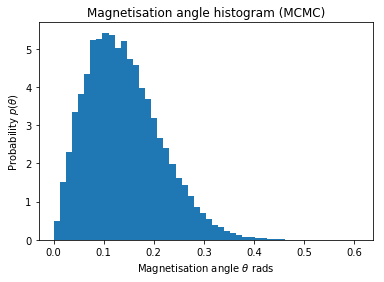

In [9]:
thetas = np.arccos(output[:, 2, :])
plt.hist(thetas[0], bins=50, normed=True)
plt.title('Magnetisation angle histogram (MCMC)')
plt.xlabel('Magnetisation angle $\\theta$ rads')
plt.ylabel('Probability $p(\\theta)$');

---

## Magpy - Dynamical Simulation

We now use Magpy to simulate a large ensemble of the identical two-particle system. Once the ensemble has reached a stationary distribution, we determine the distribution of magnetisation angles over the ensemble. We expect this distribution to match the equilibrium distribution determined by the MCMC sampler.

### Define the Magpy model

In [10]:
# additionally we must specify damping
alpha = 0.1

# We build a model of the two particles
base_model = mp.Model(
    anisotropy=[K,K],
    anisotropy_axis=anisotropy_axes,
    damping=alpha,
    location=positions,
    magnetisation=Ms,
    magnetisation_direction=moments,
    radius=[r, r],
    temperature=T
)

# Create an ensemble of 50,000 identical models
ensemble = mp.EnsembleModel(50000, base_model)

### Simulate the ensemble!

Now we run the dynamical simulation using an implicit solver. Each model is simulated for 1ns.

In [11]:
res = ensemble.simulate(end_time=1e-9, time_step=1e-12,
                        max_samples=500, random_state=1002,
                        n_jobs=-1, implicit_solve=True,
                        interactions=True)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2480 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 4496 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 5720 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7088 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 8600 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 10256 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 12056 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 14000 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 16088 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 18320 tasks      | elapsed

### Compute the final state

We use the `Results.final_state()` function to determine the state of each member of the ensemble after 1ns of simulation. The magnetisation angle is computed as the cosine of the $z$-axis component of magnetisation.

In [12]:
m_z0 = np.array([state['z'][0] for state in res.final_state()])/Ms
m_z1 = np.array([state['z'][1] for state in res.final_state()])/Ms
theta0 = np.arccos(m_z0)
theta1 = np.arccos(m_z1)

---
## Compare results

### Single variable comparison

Below we compare the magnetisation angle distribution for a single particle as simulated with Magpy and the MCMC algorithm.

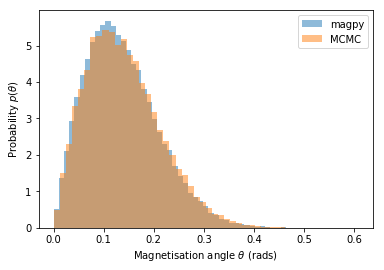

In [13]:
plt.hist(theta0, bins=50, alpha=0.5, normed=True, label='magpy')
plt.hist(thetas[0], bins=50, alpha=0.5, normed=True, label='MCMC')
plt.legend();
plt.xlabel('Magnetisation angle $\\theta$ (rads)')
plt.ylabel('Probability $p(\\theta)$');

The results look to be a good match!

### Join distribution comparison

Below we compare the joint distribution of $\theta_0$ and $\theta_1$ (the magnetisation angle of both particles). In other words, this is the probability distribution over the entire state space. It is important to compare the joint distributions because the two particles interact with one another, creating a dependence between the two magnetisation angles.

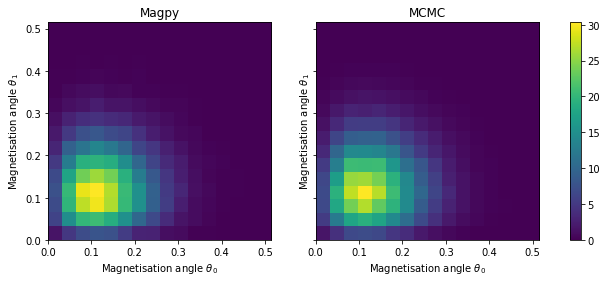

In [26]:
fg, axs = plt.subplots(ncols=2, figsize=(11,4), sharey=True)
histdat = axs[0].hist2d(theta0, theta1, bins=16, normed=True)
axs[1].hist2d(thetas[0], thetas[1], bins=histdat[1], normed=True);
for ax, title in zip(axs, ['Magpy', 'MCMC']):
    ax.set_xlabel('Magnetisation angle $\\theta_0$')
    ax.set_ylabel('Magnetisation angle $\\theta_1$')
    ax.set_title(title)
fg.colorbar(histdat[3], ax=axs.tolist());

#### Alternatively compare using a kernel density function

An alternative method to visually compare the two distributions is to construct a kernel density estimation one set of results and overaly it on a histogram of the other.

In [27]:
from scipy.stats import gaussian_kde
kde = gaussian_kde(thetas)

tgrid_x = np.linspace(theta0.min(), theta0.max(), 16)
tgrid_y = np.linspace(theta1.min(), theta1.max(), 16)
tgrid_x, tgrid_y = np.meshgrid(tgrid_x, tgrid_y)
Z = np.reshape(kde(np.vstack([tgrid_x.ravel(), tgrid_y.ravel()])).T, tgrid_x.shape)

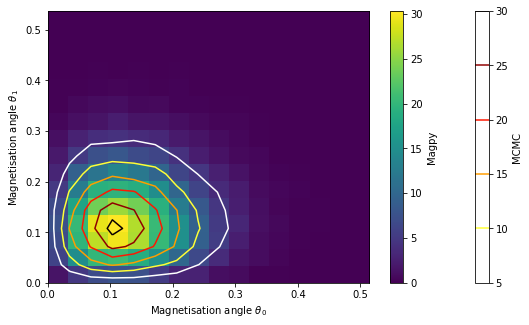

In [57]:
fg, ax = plt.subplots(figsize=(9,5))

hist = ax.hist2d(theta0, theta1, bins=16, normed=True)
contour = ax.contour(tgrid_x, tgrid_y, Z, cmap='hot_r')

fg.colorbar(contour, label='MCMC')
fg.colorbar(hist[3], label='Magpy')
ax.set_xlabel('Magnetisation angle $\\theta_0$')
ax.set_ylabel('Magnetisation angle $\\theta_1$');

## Sanity check: no interactions

To ensure that the interactions are having a significant effect on the joint distribution, we simulate the same system but disable the interaction false (simply set `interactions=False`).

In [58]:
res_noi = ensemble.simulate(end_time=1e-9, time_step=1e-12,
                        max_samples=500, random_state=1002,
                        n_jobs=-1, implicit_solve=True,
                        interactions=False)
m_z0 = np.array([state['z'][0] for state in res_noi.final_state()])/Ms
m_z1 = np.array([state['z'][1] for state in res_noi.final_state()])/Ms
theta0_noi = np.arccos(m_z0)
theta1_noi = np.arccos(m_z1)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2480 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 4496 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 5720 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 7088 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 8600 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 10256 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 12056 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 14000 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 16088 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 18320 tasks      | elapsed

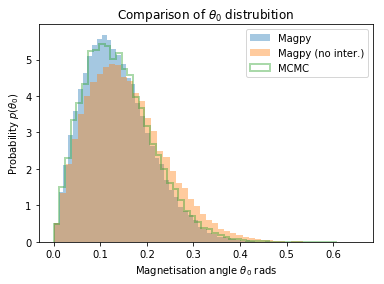

In [63]:
plt.hist(theta0, bins=50, normed=True, alpha=0.4, label='Magpy')
plt.hist(theta0_noi, bins=50, normed=True, alpha=0.4, label='Magpy (no inter.)');
plt.hist(thetas[0], bins=50, histtype='step', lw=2, normed=True, alpha=0.4, label='MCMC')
plt.legend();
plt.xlabel('Magnetisation angle $\\theta_0$ rads')
plt.ylabel('Probability $p(\\theta_0)$');
plt.title('Comparison of $\\theta_0$ distrubition');

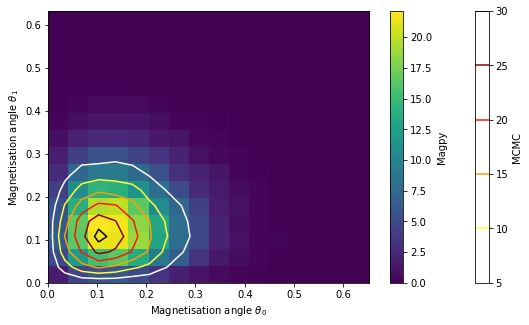

In [66]:
fg, ax = plt.subplots(figsize=(9,5))

hist = ax.hist2d(theta0_noi, theta1_noi, bins=16, normed=True)
contour = ax.contour(tgrid_x, tgrid_y, Z, cmap='hot_r')

fg.colorbar(contour, label='MCMC')
fg.colorbar(hist[3], label='Magpy')
ax.set_xlabel('Magnetisation angle $\\theta_0$')
ax.set_ylabel('Magnetisation angle $\\theta_1$');

The results show that the distributions cleary deviate when we ignore interactions.